#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


# Homework 2 - Unsupervised Deep Learning

## General overview
In this homework you will learn how to implement and test neural network models for solving unsupervised problems. For simplicity and to allow continuity with the kind of data you have seen before, the homework will be based on images of handwritten digits (MNIST). However, you can optionally explore different image collections (e.g., [Caltech](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) or [Cifar](https://www.cs.toronto.edu/~kriz/cifar.html)) or other datasets based on your interests. The basic tasks for the homework will require to test and analyze the convolutional autoencoder implemented during the Lab practice. If you prefer, you can opt for a fully-connected autoencoder, which should achieve similar performance considering the relatively small size of the MNIST images. As for the previous homework, you should explore the use of advanced optimizers and regularization methods. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. More advanced tasks will require the exploration of denoising and variational architectures.



## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework. If your code will be entirely included in a single Python notebook, just upload the notebook file.




## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length must not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional).




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	1 pt: implement and test (convolutional) autoencoder, reporting the trend of reconstruction loss and some examples of image reconstruction
*	1 pt: explore advanced optimizers and regularization methods 
*	1 pt: optimize hyperparameters using grid/random search and cross-validation
*	1 pt: implement and test denoising (convolutional) autoencoder
*	1 pt: fine-tune the (convolutional) autoencoder using a supervised classification task (you can compare classification accuracy and learning speed with results achieved in homework 1)
*	1 pt: explore the latent space structure (e.g., PCA, t-SNE) and generate new samples from latent codes
*	2 pt: implement variational (convolutional) autoencoder or GAN




## Deadline
The complete homework (source code + report) must be submitted through Moodle at least 10 days before the chosen exam date.

In [ ]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
import itertools

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F

### Set the random seed for reproducible results
torch.manual_seed(0)

## Dataset

In [ ]:
### Download the data and create dataset
data_dir = 'dataset'
# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


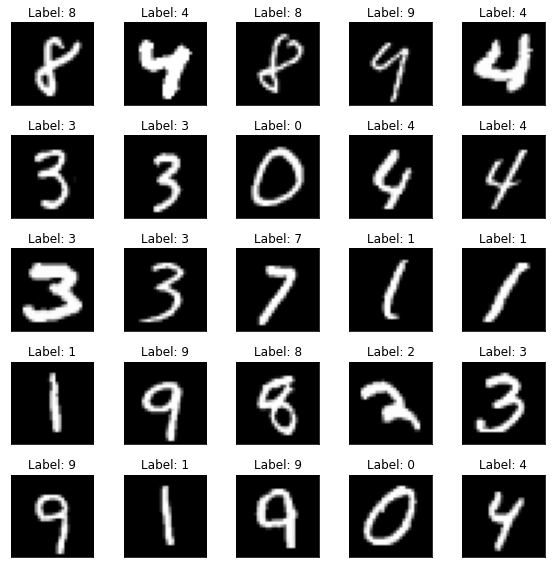

In [ ]:
### Plot some sample
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [ ]:
### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


## Autoencoder

### Encoder

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim, dropout=0):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            # Second convolutional layer
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            # Third convolutional layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(288, 64),
            nn.ReLU(),
            # Second linear layer
            nn.Linear(64, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x) 
        # Apply linear layers
        x = self.encoder_lin(x) 
        return x

# simple check of the shape 
sample = next(iter(train_dataloader)) # returns the first sample 
sample = sample[0] # actual image
print(sample.shape)

encoded_space_dim = 2 
enc = Encoder(encoded_space_dim) 
out = enc(sample) 
print(out.shape)

torch.Size([256, 1, 28, 28])
torch.Size([256, 2])


### Decoder

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim, dropout=0):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(64, 3 * 3 * 32),
            nn.ReLU(True),
            nn.Dropout(p=dropout)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

## Training and testing functions

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch) 
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.data))
    return loss.data

In [ ]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data) 
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [ ]:
def fit(num_epochs, encoder, decoder, device, train_dataloader, loss_fn, optim, test_dataloader, test_dataset, patience, plot_progress=False):
    train_loss_log = []
    val_loss_log = [] 
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=False)
    for epoch in range(num_epochs):
        print('EPOCH %d/%d' % (epoch + 1, num_epochs))
        ### Training (use the training function)
        train_loss = train_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optim)
        train_loss_log.append(train_loss)
        ### Validation (use the testing function)
        val_loss = test_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=test_dataloader, 
            loss_fn=loss_fn)
        val_loss_log.append(val_loss)
        # Print Validationloss
        print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(val_loss, decoder)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        ### Plot progress
        if plot_progress:
            # Get the output of a specific image (the test image at index 0 in this case)
            img = test_dataset[0][0].unsqueeze(0).to(device)
            encoder.eval()
            decoder.eval()
            with torch.no_grad():
                rec_img = decoder(encoder(img))
            # Plot the reconstructed image
            fig, axs = plt.subplots(1, 2, figsize=(12,6))
            axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
            axs[0].set_title('Original image')
            axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
            axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
            plt.tight_layout()
            plt.pause(0.1)
            # Save figures
            os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
            fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
            plt.show()
            plt.close()
        # Save network parameters
        #torch.save(encoder.state_dict(), 'encoder_params.pth')
        #torch.save(decoder.state_dict(), 'decoder_params.pth')
        #torch.save(optim.state_dict(), 'optim_params.pth')
    return train_loss_log, val_loss_log 

## Hyperparameter search

In [ ]:
# Hyperparameters
encoded_space_dim = [4, 8, 16]
num_epochs = [50, 100, 150]
lr = [1e-2, 1e-3, 1e-4]
decay = [1e-3, 1e-4, 1e-5]
dropout = [0]
patience = [5]

hyperparams = [encoded_space_dim, num_epochs, lr, decay, dropout, patience]
configs = list(itertools.product(*hyperparams))
print('Possible combinations:', len(configs))

Possible combinations: 81


In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

best_loss = None
best_hp = None
for iteration, hp in enumerate(configs):
    print('--------------------------------------------------------')
    print('Iteration:', iteration)
    print('Hyperparameters:', hp)
    # Loss function
    loss_fn = nn.MSELoss()
    # Iteration's hyperparameters
    encoded_space_dim, num_epochs, lr, decay, dropout, patience = hp
    # Networks
    encoder = Encoder(encoded_space_dim=encoded_space_dim, dropout=dropout) 
    decoder = Decoder(encoded_space_dim=encoded_space_dim, dropout=dropout)
    # Optimizers
    autoenc_params = [{'params': encoder.parameters()}, 
                      {'params': decoder.parameters()}]
    optim = torch.optim.Adam(autoenc_params, lr=lr, weight_decay=decay) 
    # Move both the encoder and the decoder to the selected device
    encoder.to(device)
    decoder.to(device)
    # Train
    train_loss_log, val_loss_log = fit(num_epochs=num_epochs,
                                       encoder=encoder,
                                       decoder=decoder,
                                       device=device,
                                       train_dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optim=optim,
                                       test_dataloader=test_dataloader,
                                       test_dataset=test_dataset,
                                       patience=patience,
                                       plot_progress=False)
    train_loss = train_loss_log[-1]
    val_loss = val_loss_log[-1]
    print('Train loss:', train_loss, '\nValidation loss:', val_loss)
    if not best_loss or val_loss < best_loss:
        best_hp = hp 
        best_loss = val_loss

print('###################################################################')
print('BEST PARAMETERS:', best_hp)

In [ ]:
print('BEST PARAMETERS:', best_hp)

BEST PARAMETERS: (16, 150, 0.001, 1e-05, 0, 5)


## Train with best parameters

In [ ]:
# If you have trained the model, comment this cell
best_hp = (16, 150, 0.001, 1e-5, 0, 5)

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Loss function
loss_fn = nn.MSELoss()
# Iteration's hyperparameters
encoded_space_dim, num_epochs, lr, decay, dropout, patience = best_hp 
# Networks
encoder = Encoder(encoded_space_dim=encoded_space_dim, dropout=dropout) 
decoder = Decoder(encoded_space_dim=encoded_space_dim, dropout=dropout)
# Optimizers
autoenc_params = [{'params': encoder.parameters()}, 
                  {'params': decoder.parameters()}]
optim = torch.optim.Adam(autoenc_params, lr=lr, weight_decay=decay) 
# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
# Train
train_loss_log, val_loss_log = fit(num_epochs=num_epochs,
                                   encoder=encoder,
                                   decoder=decoder,
                                   device=device,
                                   train_dataloader=train_dataloader,
                                   loss_fn=loss_fn,
                                   optim=optim,
                                   test_dataloader=test_dataloader,
                                   test_dataset=test_dataset,
                                   patience=patience,
                                   plot_progress=False)

print('Train loss:', train_loss_log[-1].detach().cpu().numpy())
print('Validation loss:', val_loss_log[-1].detach().cpu().numpy())

# Save network parameters
torch.save(encoder.state_dict(), 'encoder_params.pth')
torch.save(decoder.state_dict(), 'decoder_params.pth')
torch.save(optim.state_dict(), 'optim_params.pth')

Selected device: cpu
EPOCH 1/150


	 VALIDATION - EPOCH 1/150 - loss: 0.067694


EPOCH 2/150


	 VALIDATION - EPOCH 2/150 - loss: 0.056057


EPOCH 3/150


	 VALIDATION - EPOCH 3/150 - loss: 0.044849


EPOCH 4/150


	 VALIDATION - EPOCH 4/150 - loss: 0.037911


EPOCH 5/150


	 VALIDATION - EPOCH 5/150 - loss: 0.031397


EPOCH 6/150


	 VALIDATION - EPOCH 6/150 - loss: 0.028028


EPOCH 7/150


	 VALIDATION - EPOCH 7/150 - loss: 0.025664


EPOCH 8/150


	 VALIDATION - EPOCH 8/150 - loss: 0.023414


EPOCH 9/150


	 VALIDATION - EPOCH 9/150 - loss: 0.022120


EPOCH 10/150


	 VALIDATION - EPOCH 10/150 - loss: 0.020332


EPOCH 11/150


	 VALIDATION - EPOCH 11/150 - loss: 0.019394


EPOCH 12/150


	 VALIDATION - EPOCH 12/150 - loss: 0.018344


EPOCH 13/150


	 VALIDATION - EPOCH 13/150 - loss: 0.017645


EPOCH 14/150


	 VALIDATION - EPOCH 14/150 - loss: 0.017277


EPOCH 15/150


	 VALIDATION - EPOCH 15/150 - loss: 0.016910


EPOCH 16/150


	 VALIDATION - EPOCH 16/150 - loss: 0.016538


EPOCH

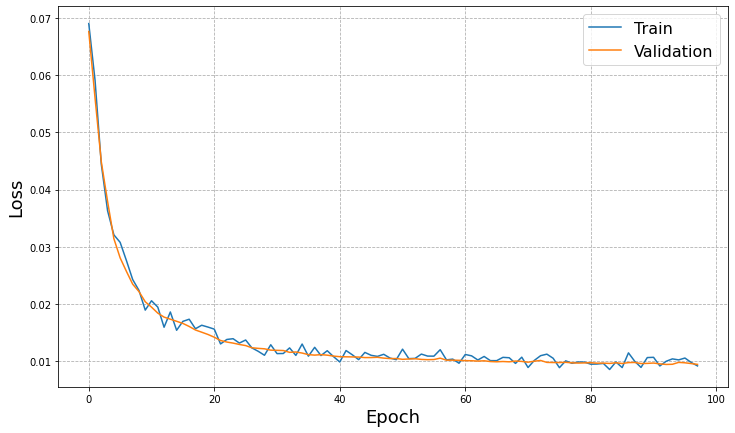

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(train_loss_log, label='Train')
plt.plot(val_loss_log, label='Validation')
#plt.yscale('log')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.grid(ls='--')
plt.legend(fontsize=16)
plt.savefig('AE_loss.pdf', bbox_inches='tight')
plt.show()

## Test the model

In [ ]:
test_loss = test_epoch(encoder=encoder,
                       decoder=decoder,
                       device=device,
                       dataloader=test_dataloader,
                       loss_fn=loss_fn)
print('Test loss', test_loss)

Test loss tensor(0.0094)


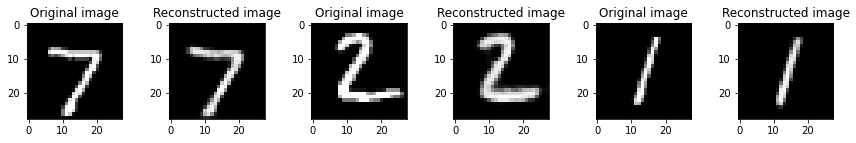

In [ ]:
# Get the output of a specific image (the test image at index 0 in this case)
img1 = test_dataset[0][0].unsqueeze(0).to(device)
img2 = test_dataset[1][0].unsqueeze(0).to(device)
img3 = test_dataset[2][0].unsqueeze(0).to(device)
encoder.eval()
decoder.eval()
with torch.no_grad():
    rec_img1 = decoder(encoder(img1))
    rec_img2 = decoder(encoder(img2))
    rec_img3 = decoder(encoder(img3))
# Plot the reconstructed image
fig, axs = plt.subplots(1, 6, figsize=(12,6))
# Image 1
axs[0].imshow(img1.cpu().squeeze().numpy(), cmap='gist_gray')
axs[0].set_title('Original image')
axs[1].imshow(rec_img1.cpu().squeeze().numpy(), cmap='gist_gray')
axs[1].set_title('Reconstructed image')
# Image 2
axs[2].imshow(img2.cpu().squeeze().numpy(), cmap='gist_gray')
axs[2].set_title('Original image')
axs[3].imshow(rec_img2.cpu().squeeze().numpy(), cmap='gist_gray')
axs[3].set_title('Reconstructed image')
# Image 3
axs[4].imshow(img3.cpu().squeeze().numpy(), cmap='gist_gray')
axs[4].set_title('Original image')
axs[5].imshow(rec_img3.cpu().squeeze().numpy(), cmap='gist_gray')
axs[5].set_title('Reconstructed image')
plt.tight_layout()
# Save figures
fig.savefig('conv-ae-reconstr.pdf', bbox_inches='tight')
plt.show()

## Network analysis

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px

In [ ]:
# Load network parameters
encoder.load_state_dict(torch.load('encoder_params.pth'))
decoder.load_state_dict(torch.load('decoder_params.pth'))

<All keys matched successfully>

In [ ]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████| 10000/10000 [00:05<00:00, 1761.26it/s]


In [ ]:
# Convert to a dataframe (for convenience)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,Enc. Variable 4,Enc. Variable 5,Enc. Variable 6,Enc. Variable 7,Enc. Variable 8,Enc. Variable 9,Enc. Variable 10,Enc. Variable 11,Enc. Variable 12,Enc. Variable 13,Enc. Variable 14,Enc. Variable 15,label
0,-0.109197,7.139547,-13.503556,7.835331,13.404855,11.945591,15.955687,6.058840,9.462335,19.695530,9.422970,3.957096,-22.199829,-39.023781,4.015503,28.242914,7
1,25.188398,-31.265732,8.974432,24.418217,-11.938396,4.951917,-1.546524,6.385215,13.121735,33.916073,-9.738850,-7.890675,21.758087,-22.998327,17.988935,10.155015,2
2,36.183861,-5.425055,12.109870,10.943657,17.807255,6.145944,3.442337,-15.779513,-14.904035,19.815834,-7.434618,-3.785298,-18.803595,-21.291761,14.076784,25.746157,1
3,13.331589,-13.062168,0.838049,0.240047,11.017655,-5.888432,19.688719,9.946958,40.223991,43.006477,-1.553163,5.718956,-0.414117,-20.550035,-12.463402,16.339794,0
4,8.586419,-0.355457,-0.207668,-19.398272,-19.208330,15.836712,6.899408,19.059597,19.218748,38.196880,-1.861047,-0.552732,-14.710436,-10.868005,-16.442663,28.700262,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,22.902874,-36.038490,-11.634806,18.626753,-6.584069,6.382146,25.486734,11.901141,18.121580,43.170757,2.934566,11.599426,-9.907870,-27.195286,24.071047,5.843359,2
9996,25.647455,-22.676920,-7.755876,18.054132,11.770608,-2.976507,16.983498,11.931012,40.613842,27.791557,10.985543,-7.426112,8.865124,-34.705925,17.336254,20.255266,3
9997,1.255270,-1.976616,-8.183794,-3.134693,23.594498,11.335660,8.777182,-1.498779,1.266393,44.192554,-17.024111,8.118774,-12.484743,-9.160384,0.039156,33.983540,4
9998,-11.821501,-3.215014,14.200577,4.633490,8.882915,-23.815142,24.760504,6.216314,18.044918,27.592525,-5.322356,0.339175,-12.178741,-13.205042,19.310911,46.635994,5


### PCA

In [ ]:
n_components = 2
pca = PCA(n_components=n_components)
pca.fit(encoded_samples.iloc[:, 0:encoded_space_dim])

pca_transf_samples = pd.DataFrame(pca.transform(encoded_samples.iloc[:, 0:encoded_space_dim]), 
                                  columns=[f'Enc. Variable {i}' for i in range(n_components)])

fig = px.scatter(pca_transf_samples, 
                 x='Enc. Variable 0', 
                 y='Enc. Variable 1', 
                 color=encoded_samples.label.astype(str), 
                 opacity=0.7)
fig.show()

### t-SNE

In [ ]:
n_components = 2
tsne = TSNE(n_components=n_components)
tsne.fit(encoded_samples.iloc[:, 0:encoded_space_dim])

tsne_tranf_samples = pd.DataFrame(tsne.fit_transform(encoded_samples.iloc[:, 0:encoded_space_dim]), 
                                  columns=[f'Enc. Variable {i}' for i in range(n_components)])

fig = px.scatter(tsne_tranf_samples, 
                 x='Enc. Variable 0', 
                 y='Enc. Variable 1', 
                 color=encoded_samples.label.astype(str), 
                 opacity=0.7)
fig.show()

## Generate new samples

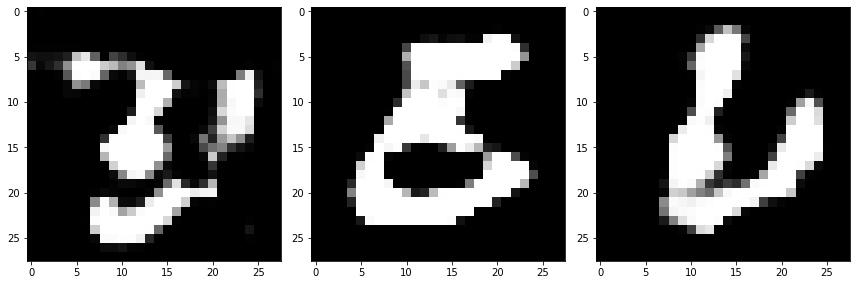

In [ ]:
# Generate a custom sample
custom_encoded_sample1 = np.random.randn(16)*50
encoded_value1 = torch.tensor(custom_encoded_sample1).float().unsqueeze(0).to(device)
custom_encoded_sample2 = np.random.randn(16)*50
encoded_value2 = torch.tensor(custom_encoded_sample2).float().unsqueeze(0).to(device)
custom_encoded_sample3 = np.random.randn(16)*50
encoded_value3 = torch.tensor(custom_encoded_sample3).float().unsqueeze(0).to(device)

# Decode sample
decoder.eval()
with torch.no_grad():
    generated_img1 = decoder(encoded_value1)
    generated_img2 = decoder(encoded_value2)
    generated_img3 = decoder(encoded_value3)

# Plot the reconstructed image
fig, axs = plt.subplots(1, 3, figsize=(12,6))
axs[0].imshow(generated_img1.cpu().squeeze().numpy(), cmap='gist_gray')
axs[1].imshow(generated_img2.cpu().squeeze().numpy(), cmap='gist_gray')
axs[2].imshow(generated_img3.cpu().squeeze().numpy(), cmap='gist_gray')
plt.tight_layout()
# Save figures
fig.savefig('conv-ae-gener.pdf', bbox_inches='tight')
plt.show()

## Denoising autoencoder

In [ ]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Add noise 
        mean = torch.randn(1).to(device)
        std = torch.randn(1).to(device) * 0.5 + 0.5
        noisy_image = image_batch + torch.randn(image_batch.size()).to(device) * std + mean
        # Encode data
        encoded_data = encoder(noisy_image)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch) 
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.data))
    return loss.data

In [ ]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Add noise
            mean = torch.randn(1).to(device)
            std = torch.randn(1).to(device) * 0.5 + 0.5
            noisy_image = image_batch + torch.randn(image_batch.size()).to(device) * std + mean 
            # Encode data
            encoded_data = encoder(noisy_image)
            # Decode data
            decoded_data = decoder(encoded_data) 
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [ ]:
best_hp = (16, 150, 0.001, 1e-5, 0, 5)

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Loss function
loss_fn = nn.MSELoss()
# Iteration's hyperparameters
encoded_space_dim, num_epochs, lr, decay, dropout, patience = best_hp 
# Networks
encoder = Encoder(encoded_space_dim=encoded_space_dim, dropout=dropout) 
decoder = Decoder(encoded_space_dim=encoded_space_dim, dropout=dropout)
# Optimizers
autoenc_params = [{'params': encoder.parameters()}, 
                  {'params': decoder.parameters()}]
optim = torch.optim.Adam(autoenc_params, lr=lr, weight_decay=decay) 
# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
# Train
train_loss_log, val_loss_log = fit(num_epochs=num_epochs,
                                   encoder=encoder,
                                   decoder=decoder,
                                   device=device,
                                   train_dataloader=train_dataloader,
                                   loss_fn=loss_fn,
                                   optim=optim,
                                   test_dataloader=test_dataloader,
                                   test_dataset=test_dataset,
                                   patience=patience,
                                   plot_progress=False)

print('Train loss:', train_loss_log[-1].detach().cpu().numpy())
print('Validation loss:', val_loss_log[-1].detach().cpu().numpy())

# Save network parameters
torch.save(encoder.state_dict(), 'denoise_encoder_params.pth')
torch.save(decoder.state_dict(), 'denoise_decoder_params.pth')
torch.save(optim.state_dict(), 'denoise_optim_params.pth')

Selected device: cpu
EPOCH 1/150


	 VALIDATION - EPOCH 1/150 - loss: 0.069677


EPOCH 2/150


	 VALIDATION - EPOCH 2/150 - loss: 0.067735


EPOCH 3/150


	 VALIDATION - EPOCH 3/150 - loss: 0.067581


EPOCH 4/150


	 VALIDATION - EPOCH 4/150 - loss: 0.067670


EarlyStopping counter: 1 out of 5
EPOCH 5/150


	 VALIDATION - EPOCH 5/150 - loss: 0.067088


EPOCH 6/150


	 VALIDATION - EPOCH 6/150 - loss: 0.065053


EPOCH 7/150


	 VALIDATION - EPOCH 7/150 - loss: 0.062084


EPOCH 8/150


	 VALIDATION - EPOCH 8/150 - loss: 0.058636


EPOCH 9/150


	 VALIDATION - EPOCH 9/150 - loss: 0.055880


EPOCH 10/150


	 VALIDATION - EPOCH 10/150 - loss: 0.053746


EPOCH 11/150


	 VALIDATION - EPOCH 11/150 - loss: 0.052237


EPOCH 12/150


	 VALIDATION - EPOCH 12/150 - loss: 0.047538


EPOCH 13/150


	 VALIDATION - EPOCH 13/150 - loss: 0.044951


EPOCH 14/150


	 VALIDATION - EPOCH 14/150 - loss: 0.042724


EPOCH 15/150


	 VALIDATION - EPOCH 15/150 - loss: 0.039870


EPOCH 16/150


	 VALIDATION - EPO

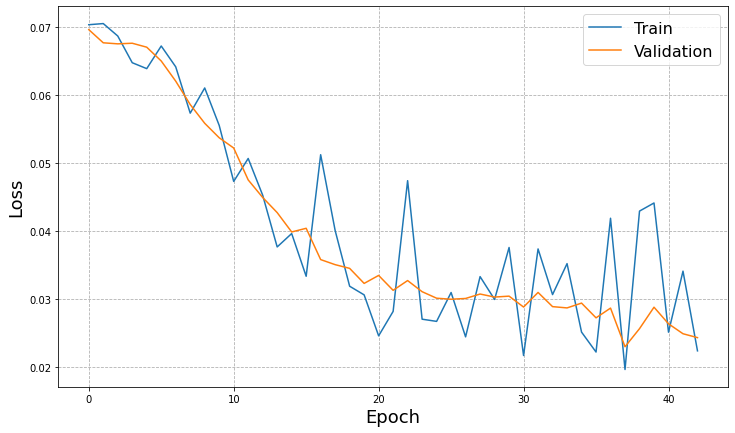

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(train_loss_log, label='Train')
plt.plot(val_loss_log, label='Validation')
#plt.yscale('log')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.grid(ls='--')
plt.legend(fontsize=16)
plt.savefig('denoise_AE_loss.pdf', bbox_inches='tight')
plt.show()

In [ ]:
test_loss = test_epoch(encoder=encoder,
                       decoder=decoder,
                       device=device,
                       dataloader=test_dataloader,
                       loss_fn=loss_fn)
print('Test loss', test_loss)

Test loss tensor(0.0269)


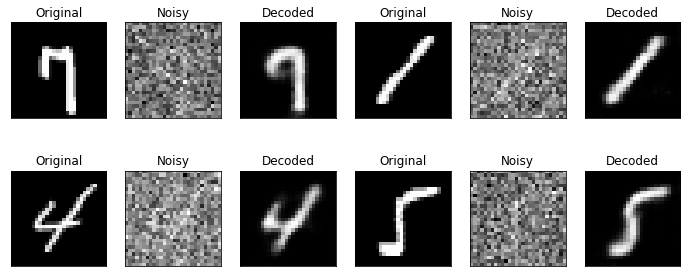

In [ ]:
fig, axs = plt.subplots(2, 6, figsize=(12,5))
for ax in axs:
    # Original
    img, label = random.choice(test_dataset)
    imgc = img[0]
    ax[0].imshow(np.array(imgc), cmap='gist_gray')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title('Original')
    # Noisy
    imgc += np.random.normal(0, 1, size=imgc.shape)
    ax[1].imshow(np.array(imgc), cmap='gist_gray')
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title('Noisy')
    # Denoised
    encoder.eval()
    decoder.eval()
    img = img.unsqueeze(0).to(device)
    with torch.no_grad():
        enc_img = encoder(img)
        dec_img = decoder(enc_img)
    ax[2].imshow(np.array(dec_img.detach().cpu()[0][0]), cmap='gist_gray')
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    ax[2].set_title('Decoded')

    img, label = random.choice(test_dataset)
    imgc = img[0]
    ax[3].imshow(np.array(imgc), cmap='gist_gray')
    ax[3].set_xticks([])
    ax[3].set_yticks([])
    ax[3].set_title('Original')
    # Noisy
    imgc += np.random.normal(0, 1, size=imgc.shape)
    ax[4].imshow(np.array(imgc), cmap='gist_gray')
    ax[4].set_xticks([])
    ax[4].set_yticks([])
    ax[4].set_title('Noisy')
    # Denoised
    encoder.eval()
    decoder.eval()
    img = img.unsqueeze(0).to(device)
    with torch.no_grad():
        enc_img = encoder(img)
        dec_img = decoder(enc_img)
    ax[5].imshow(np.array(dec_img.detach().cpu()[0][0]), cmap='gist_gray')
    ax[5].set_xticks([])
    ax[5].set_yticks([])
    ax[5].set_title('Decoded')

plt.savefig('denoise.pdf', bbox_inches='tight')

## Fine-tune the AE using a supervised classification task

In [ ]:
encoder = Encoder(encoded_space_dim=16, dropout=0)

In [ ]:
encoder.load_state_dict(torch.load('encoder_params.pth'))

<All keys matched successfully>

In [ ]:
encoder

Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
    (6): Dropout2d(p=0, inplace=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=16, bias=True)
  )
)

In [ ]:
class Classifier(nn.Module):
    def __init__(self, encoded_space_dim, pretrained_encoder):
        super().__init__()
        # Encoder
        self.encoder = pretrained_encoder
        # Fine tune layers for classification
        self.fine_tune_class = nn.Sequential(nn.Linear(encoded_space_dim, 64),
                                             nn.ReLU(True),
                                             nn.Linear(64, 10),
                                             nn.LogSoftmax(dim=-1))
        #self.fine_tune_class = nn.Linear(encoded_space_dim, 10)

    def forward(self, x):
        x = self.encoder(x)
        x = self.fine_tune_class(x)
        return x

    def fit(self, train_loader, val_loader, loss_function, optimizer, num_epochs, device):
        train_loss_log = []
        val_loss_log = []
        # initialize the early_stopping object
        early_stopping = EarlyStopping(patience=5, verbose=False)
        for epoch_num in range(num_epochs):
            print('------------------------------------------------------------')
            print(f'EPOCH {epoch_num}')
            # ....................... TRAIN .......................
            train_loss = []
            self.train() # Training mode (e.g. enable dropout)
            for sample_batched in train_loader:
                # Move data to device
                x = sample_batched[0].to(device)
                label = sample_batched[1].to(device)
                # Forward pass
                out = self.forward(x)
                # Compute loss
                loss = loss_function(out, label)
                # Backpropagation
                self.zero_grad()
                loss.backward()
                # Update the weights
                optimizer.step()
                # Save train loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                train_loss.append(loss_batch)
            # Save average train loss 
            train_loss = np.mean(train_loss)
            print(f"Average train loss: {train_loss}")
            train_loss_log.append(train_loss)
            # .................... VALIDATION .....................
            val_loss= []
            self.eval() # Evaluation mode (e.g. disable dropout)
            with torch.no_grad(): # Disable gradient tracking
                for sample_batched in val_loader:
                    # Move data to device
                    x = sample_batched[0].to(device)
                    label = sample_batched[1].to(device)
                    # Forward pass
                    out = self.forward(x)
                    # Compute loss
                    loss = loss_function(out, label)
                    # Save val loss for this batch
                    loss_batch = loss.detach().cpu().numpy()
                    val_loss.append(loss_batch)
            # Save average validation loss
            val_loss = np.mean(val_loss)
            print(f"Average validation loss: {np.mean(val_loss)}")
            val_loss_log.append(val_loss)
            # early_stopping needs the validation loss to check if it has decresed, 
            # and if it has, it will make a checkpoint of the current model
            early_stopping(val_loss, self)
            if early_stopping.early_stop:
                print("Early stopping")
                break
        return train_loss_log, val_loss_log

In [ ]:
class_net = Classifier(encoded_space_dim=16, pretrained_encoder=encoder)

In [ ]:
# Disallow the update of all the layers by setting the 'requires_grad' parameter of the tensors to 'False'
for param_name, param in class_net.encoder.named_parameters():
    #print(param_name)
    #print('\tFreezing update')
    param.requires_grad = False

In [ ]:
# Check if correct
for param_name, param in class_net.named_parameters():
    print('%s \t- requires_grad=%s' % (param_name, param.requires_grad))

encoder.encoder_cnn.0.weight 	- requires_grad=False
encoder.encoder_cnn.0.bias 	- requires_grad=False
encoder.encoder_cnn.2.weight 	- requires_grad=False
encoder.encoder_cnn.2.bias 	- requires_grad=False
encoder.encoder_cnn.4.weight 	- requires_grad=False
encoder.encoder_cnn.4.bias 	- requires_grad=False
encoder.encoder_lin.0.weight 	- requires_grad=False
encoder.encoder_lin.0.bias 	- requires_grad=False
encoder.encoder_lin.2.weight 	- requires_grad=False
encoder.encoder_lin.2.bias 	- requires_grad=False
fine_tune_class.0.weight 	- requires_grad=True
fine_tune_class.0.bias 	- requires_grad=True
fine_tune_class.2.weight 	- requires_grad=True
fine_tune_class.2.bias 	- requires_grad=True


In [ ]:
# Define a loss function 
#loss_fn = nn.CrossEntropyLoss() 
loss_fn = nn.NLLLoss()

# Define an optimizer
optim = torch.optim.Adam(class_net.parameters(), lr=0.001, weight_decay=1e-5) 

# Select the proper device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Move all the network parameters to the selected device
class_net.to(device) 

Classifier(
  (encoder): Encoder(
    (encoder_cnn): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
      (5): ReLU()
      (6): Dropout2d(p=0, inplace=False)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (encoder_lin): Sequential(
      (0): Linear(in_features=288, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=16, bias=True)
    )
  )
  (fine_tune_class): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=10, bias=True)
    (3): LogSoftmax(dim=-1)
  )
)

In [ ]:
# Create a validation dataloader
train_set, val_set = torch.utils.data.random_split(train_dataset, 
                                                   [int(0.2*len(train_dataset)), int(0.8*len(train_dataset))])

### Define train dataloader
train_dataloader = DataLoader(train_set, batch_size=256, shuffle=True)
### Define validation dataloader
val_dataloader = DataLoader(val_set, batch_size=256, shuffle=False)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [ ]:
train_loss_log, val_loss_log = class_net.fit(train_loader=train_dataloader, 
                                             val_loader=val_dataloader, 
                                             loss_function=loss_fn, 
                                             optimizer=optim, 
                                             num_epochs=20, 
                                             device=device)

------------------------------------------------------------
EPOCH 0
Average train loss: 3.4118223190307617
Average validation loss: 0.9614511132240295
------------------------------------------------------------
EPOCH 1
Average train loss: 0.6663661003112793
Average validation loss: 0.502221941947937
------------------------------------------------------------
EPOCH 2
Average train loss: 0.43992072343826294
Average validation loss: 0.38921982049942017
------------------------------------------------------------
EPOCH 3
Average train loss: 0.3584699034690857
Average validation loss: 0.33387964963912964
------------------------------------------------------------
EPOCH 4
Average train loss: 0.3137856721878052
Average validation loss: 0.3006431460380554
------------------------------------------------------------
EPOCH 5
Average train loss: 0.2837814688682556
Average validation loss: 0.27623656392097473
------------------------------------------------------------
EPOCH 6
Average train lo

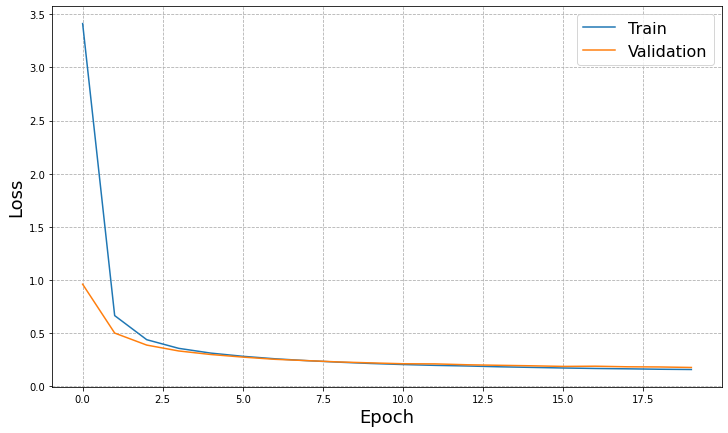

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(train_loss_log, label='Train')
plt.plot(val_loss_log, label='Validation')
#plt.yscale('log')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.grid(ls='--')
plt.legend(fontsize=16)
plt.savefig('finetune_loss.pdf', bbox_inches='tight')
plt.show()

In [ ]:
test_loss = []
outputs = [] 
labels = []

class_net.eval()
with torch.no_grad(): 
    for sample_batched in test_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label = sample_batched[1].to(device)
        # Compute net output
        out = class_net(x_batch)
        outputs.append(out)
        labels.append(label)
        # Append the network output and the original image to the lists
        loss = loss_fn(out, label)
        test_loss.append(loss.detach().cpu().numpy())
# concatenate the outputs and labels in a single tensor
outputs = torch.cat(outputs)
labels = torch.cat(labels)
test_loss = np.mean(test_loss)

print("Test loss:", test_loss)

Test loss: 0.16428946


In [ ]:
outputs = outputs.detach().cpu().numpy()
labels = labels.detach().cpu().numpy()

In [ ]:
predicted_labels = [outputs[i].argmax() for i in range(len(outputs))]
diffs = np.array([predicted_labels[i]-labels[i] for i in range(len(outputs))])
wrong = np.count_nonzero(diffs) 
test_accuracy = 1 - wrong/len(outputs)
print("Test accuracy: ", test_accuracy)

Test accuracy:  0.9513


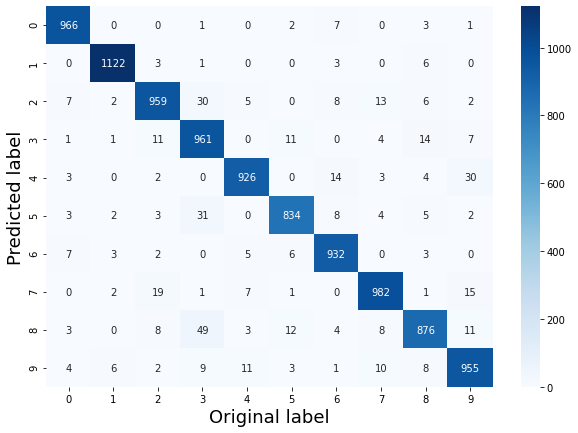

In [ ]:
### Confusion matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns

# Evaluate confusion matrix
cm = confusion_matrix(labels, predicted_labels)
# Show the confusion matrix
df_cm = pd.DataFrame(cm)
plt.figure(figsize=(10,7))
sns.heatmap(df_cm, cmap='Blues', fmt='d', annot=True)
plt.xlabel('Original label', fontsize=18)
plt.ylabel('Predicted label', fontsize=18)
plt.savefig('cm.pdf')
plt.show()

## Variational Autoencoder

### Linear Variational Autoencoder

In [ ]:
class VAE(nn.Module):
    
    def __init__(self, x, h1, h2, z):
        super(VAE, self).__init__()
        
        # Encoder part
        self.fc1 = nn.Linear(x, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc31 = nn.Linear(h2, z)
        self.fc32 = nn.Linear(h2, z)
        # Decoder part
        self.fc4 = nn.Linear(z, h2)
        self.fc5 = nn.Linear(h2, h1)
        self.fc6 = nn.Linear(h1, x)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return torch.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

In [ ]:
vae = VAE(x=784, h1=512, h2=256, z=9)

In [ ]:
vae.to(device)

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=9, bias=True)
  (fc32): Linear(in_features=256, out_features=9, bias=True)
  (fc4): Linear(in_features=9, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [ ]:
optimizer = torch.optim.Adam(vae.parameters())

# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [ ]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_dataloader):
        data = data[0].to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_dataloader.dataset)))

def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_dataloader:
            data = data.to(device)
            recon, mu, log_var = vae(data)
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_dataloader.dataset)
    print('Test set loss: {:.4f}'.format(test_loss))

for epoch in range(1, 51):
    train(epoch)
    test()

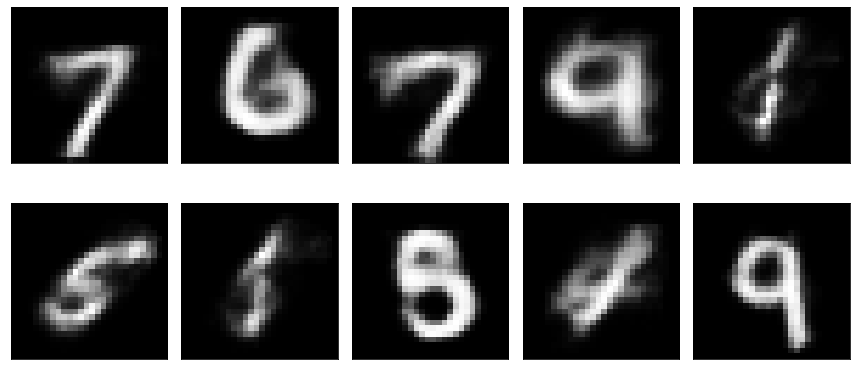

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(12,6))
for ax in axs.flatten():
    with torch.no_grad():
        z = torch.randn(1, 9).to(device)
        sample = vae.decoder(z).to(device)
    sample=sample.view(1, 1, 28, 28)[0].cpu().squeeze().numpy()
    ax.imshow(sample, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig('vae_generation.pdf', bbox_inches='tight')
plt.tight_layout()

### Convolutional Variational Autoencoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim=16, capacity=64):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=encoded_space_dim)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=encoded_space_dim)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=encoded_space_dim, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x
    
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
def vae_loss(recon_x, x, mu, logvar, variational_beta=1):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + variational_beta * kldivergence
    
    
vae = VariationalAutoencoder()

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

In [ ]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=0.001, weight_decay=1e-5)

vae.train()

train_loss_avg = []
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    for image_batch, _ in train_dataloader:
        image_batch = image_batch.to(device)
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_avg[-1] += loss.item()
        num_batches += 1
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(train_loss_log, label='Train')
#plt.yscale('log')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.grid(ls='--')
plt.legend(fontsize=16)
plt.savefig('ConvVAE_loss.pdf', bbox_inches='tight')
plt.show()

In [ ]:
vae.eval()

test_loss_avg = 0
num_batches = 0
for image_batch, _ in test_dataloader:
    with torch.no_grad():
        image_batch = image_batch.to(device)
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        test_loss_avg += loss.item()
        num_batches += 1
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

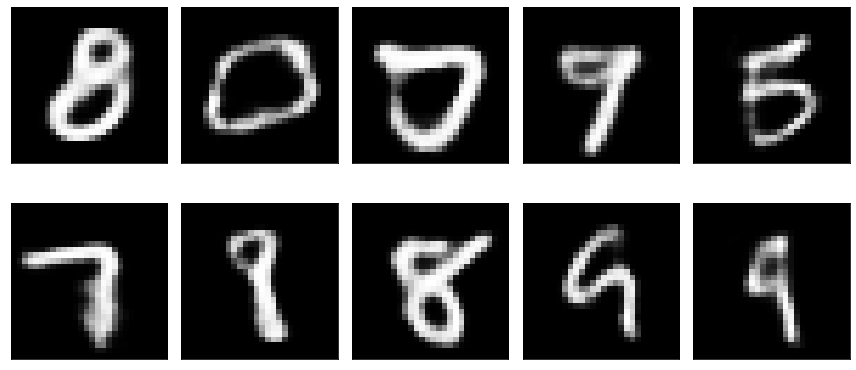

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(12,6))
for ax in axs.flatten():
    with torch.no_grad():
        #z = torch.randn(1, 16).to(device)
        z = torch.randn(1, latent_dims, device=device)
        sample = vae.decoder(z).to(device)
    sample=sample.view(1, 1, 28, 28)[0].cpu().squeeze().numpy()
    ax.imshow(sample, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig('vae_generation.pdf', bbox_inches='tight')
plt.tight_layout()